In [ ]:
!pip install transformers
!pip install seqeval
!pip install datasets
!pip install accelerate -U

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Disable CUDA
# torch.backends.cudnn.enabled = False
# torch.cuda.is_available = lambda : False

# Datset Handling

In [3]:
from datasets import get_dataset_config_names,load_dataset,DatasetDict
from collections import defaultdict
import pandas as pd
from collections import Counter

In [4]:
#dataset....we are using is Cross-Lingual Cross-lingual TRansfer Evaluation of
#Multilingual Encoders (XTREME) benchmark called WikiANN or PAN-X.
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [5]:
langs = ['de','fr','it','en'] #German, French, Italian, English popular langs in switzerland...
fracs = [0.629, 0.229, 0.084, 0.059] #fraction of each language that we are interested in...

#creating dataset dict for pytorch training...
pan_x = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        pan_x[lang][split] = (
        ds[split]
        .shuffle(seed=0)
        .select(range(int(frac * ds[split].num_rows))))

In [6]:
pd.DataFrame({lang: [pan_x[lang]["train"].num_rows] for lang in langs},
index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [7]:
element = pan_x['de']["train"][0]
for key,value in element.items():
    print(f"{key}, {value}")

tokens, ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags, [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs, ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
#knowing attributes of dataset object
for key, value in pan_x["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
#available NER tags...
tags = pan_x['de']['train'].features['ner_tags'].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [10]:
#converting ner_tags ids into string values
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [11]:
#applying it to German Dataset
panx_de = pan_x['de'].map(create_tag_names)

In [12]:
#example of German tokens.....
de_element = panx_de['train'][0]
for key, value in de_element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']
ner_tags_str: ['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O']


In [13]:
#Counting number of ner tags present in each split
split2freq = defaultdict(Counter)

for split,dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freq[split][tag_type] += 1
pd.DataFrame.from_dict(split2freq, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


# Tokenization

In [14]:
#Multilingual XLM-R uses SentencePiece tokenizer
#Comparision between tokenization of BERT (WordPiece) and XLM-R(SentencePiece)
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [15]:
#example text....
text = "Jack Sparrow loves New York!"

bert_tokens = bert_tokenizer(text)
xlmr_tokens = xlmr_tokenizer(text)

In [16]:
print(f"BERT Tokenizer output : \n {bert_tokens.tokens()}")
print(f"XLM-R Tokenizer output : \n {xlmr_tokens.tokens()}")

BERT Tokenizer output : 
 ['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
XLM-R Tokenizer output : 
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


In [17]:
import torch.nn as nn
import torch
import numpy as np

from transformers import XLMRobertaConfig,TrainingArguments,Trainer
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoConfig
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

In [18]:
#Creating custom model for the TokenClassification using XLM_Roberta Model....
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,labels=None,**kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
        token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,hidden_states=outputs.hidden_states,attentions=outputs.attentions)



In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [20]:
#adding extra keys-values to already existing config file of XLMR
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes,id2label=index2tag,label2id=tag2index)

In [21]:
#loading custom model we created using from_pretrained
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config).to(device)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
#test input
inputs = xlmr_tokenizer.encode(text,return_tensors='pt')
pd.DataFrame([xlmr_tokens.tokens(),inputs[0].numpy()],index=['Tokens',"Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [23]:
#sending input_ids to models and getting predictions....
output = xlmr_model(inputs.to(device)).logits
predictions = torch.argmax(output, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens.tokens())}")
print(f"Shape of outputs: {output.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [24]:
preds = [tags.names[e] for e in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens.tokens(),preds],index=["Tokens","Predictions"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Predictions,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


In [25]:
#Method to create tag texts....
def tag_text(text,tags,model,tokenizer):

    #get tokens from text
    tokens = tokenizer(text).tokens()

    #get input ids
    input_ids = xlmr_tokenizer(text,return_tensors='pt').input_ids.to(device)

    #get logits from model
    output = model(input_ids)[0]

    #get predictions
    predictions = torch.argmax(output,dim=-1)

    #convert to predictions
    preds  = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens,preds],index=['Tokens',"Tags"])

In [26]:
tag_text(text,tags,xlmr_model,xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG


In [27]:
words,labels = de_element['tokens'],de_element['ner_tags']
print(words)
print(labels)

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


In [28]:
#creating input_ids using tokens present in the input and labels
tokenized_input = xlmr_tokenizer(de_element['tokens'],is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens],index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [29]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [30]:
#We would like to mask subwords with special character so that previous word tokens are not get confused during training..
prev_word_id = None
label_ids = []

for word_id in word_ids:
    if word_id is None or word_id == prev_word_id:
        label_ids.append(-100)
    elif word_id != prev_word_id:
        label_ids.append(labels[word_id])
    prev_word_id = word_id

labels = [index2tag[l] if l!= -100 else "IGN" for l in label_ids]

In [31]:
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [32]:
#collecting whole approach into single function

def tokenize_and_align_labels(examples):

    tokenized_inputs = xlmr_tokenizer(examples['tokens'],truncation=True,is_split_into_words=True)
#     tokens = xlmr_tokenizer.convert_ids_to_tokens()
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else :
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
    remove_columns=['langs', 'ner_tags', 'tokens'])

In [33]:
#creating subset of each dataset split....
# subset_data = {}
# for split,dataset in pan_x["de"].items():
#     subset_data[split] = dataset.select(range(4000))
# subset_data_dict = DatasetDict(subset_data)
#encoding whole dataset
panx_de_encoded = encode_panx_dataset(pan_x['de'])

# #encoding subset of dataset
# panx_de_encoded = encode_panx_dataset(subset_data_dict)

In [34]:
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

In [35]:
#Performance Metrics.....
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [36]:
#Function to integrate them with model ouptuts
def align_predictions(predictions,label_ids):
    preds = np.argmax(predictions,axis=-1)
    batch_size,seq_len = preds.shape

    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
      example_labels, example_preds = [], []
      for seq in range(seq_len):
          if label_ids[batch_idx,seq]!=-100:
              example_labels.append(index2tag[label_ids[batch_idx][seq]])
              example_preds.append(index2tag[preds[batch_idx][seq]])
      labels_list.append(example_labels)
      preds_list.append(example_preds)

    return preds_list,labels_list

In [37]:

num_epochs = 3
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(output_dir=model_name,
                                  overwrite_output_dir=True,
                                  log_level="error",
                                  num_train_epochs=num_epochs,
                                  evaluation_strategy="epoch",
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_total_limit=1)

In [38]:
#evaluation function on metrics F1-Score
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [39]:
from transformers import DataCollatorForTokenClassification
#data collator to pad sequences to largest seq len in the batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [87]:
#model init to initialize the model for training...
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))


In [71]:
loaded_model = XLMRobertaForTokenClassification.from_pretrained('/content/xlm-roberta-base-finetuned-panx-de/checkpoint-500', config=xlmr_config).to(device)

In [72]:
trainer = Trainer(model = loaded_model,#model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [86]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1
1,0.247400,0.161023,0.821939
2,0.124300,0.153168,0.844477
3,0.077400,0.147407,0.861138


TrainOutput(global_step=2361, training_loss=0.14956603301487853, metrics={'train_runtime': 680.4748, 'train_samples_per_second': 55.461, 'train_steps_per_second': 3.47, 'total_flos': 792120179120688.0, 'train_loss': 0.14956603301487853, 'epoch': 3.0})

In [ ]:
# trainer.save_model()

In [42]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# Error Analysis

In [45]:
from torch.nn.functional import cross_entropy

In [43]:
def forward_pass_with_labels(batch):
    #converting dict of lists to list of dicts for suitable data collator
    features = [dict(zip(batch,t)) for t in zip(*batch.values())]

    #pad inputs and labels
    batch = data_collator(features)

    #inputs to model
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    #evaluation of model on batch
    with torch.no_grad():

        #Pass data through model
        output = trainer.model(input_ids,attention_mask)

        #logit.size : [batch_size,seq_length,classes]
        #predict class with largest logit value on class axis
        predicted_label = torch.argmax(output.logits,axis=-1)

    #calculate loss per token after flattening batch dimension
    loss = cross_entropy(output.logits.view(-1,7),labels.view(-1),reduction="none")

    #unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids),-1).cpu().numpy()

    return {"loss" : loss, "predicted_label" : predicted_label}


In [ ]:
#applying above function on the validation set
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_labels,batched=True,batch_size=8)
df = valid_set.to_pandas()

In [47]:
#converting input ids to tokens and labelids to labels
index2tag[-100] = "IGN"
df['input_tokens'] = df['input_ids'].apply(lambda x:xlmr_tokenizer.convert_ids_to_tokens(x))
df['predicted_label'] = df['predicted_label'].apply(lambda x : [index2tag[i] for i in x])
df['labels'] = df['labels'].apply(lambda x : [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x : x['loss'][:len(x['input_ids'])],axis=1)
df['predicted_label'] = df.apply(lambda x:x['predicted_label'][:len(x['input_ids'])],axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.022536008, 0.0, 0.011696451, 0.0087751...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [48]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels!='IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

<ipython-input-48-231238f26195>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.02,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.24,B-LOC,▁Luz
1,10,1,I-ORG,1.29,I-LOC,▁a


In [49]:
#loss over tokens
(df_tokens.groupby("input_tokens")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1) # Get rid of multi-level columns
.sort_values(by="sum", ascending=False)
.reset_index()
.round(2)
.head(10)
.T)


,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁von,▁in,▁und,▁/,▁(,▁),▁'',▁A
count,6066,1388,808,989,1171,163,246,246,2898,125
mean,0.04,0.1,0.18,0.14,0.09,0.61,0.36,0.33,0.02,0.48
sum,243.51,145.05,143.72,133.79,100.66,99.36,89.52,81.3,66.7,59.9


In [50]:
#loss over labels
(df_tokens.groupby("labels")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1)
.sort_values(by="mean", ascending=False)
.reset_index()
.round(2)
.T)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.73,0.72,0.52,0.36,0.31,0.22,0.04
sum,1949.13,1054.2,1998.35,1151.18,901.98,916.71,1557.68


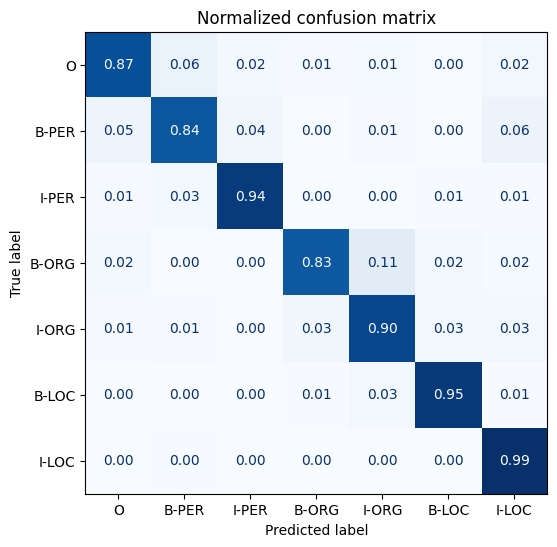

In [51]:
#plotting confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds,y_true,labels):

    cm = confusion_matrix(y_true,y_preds,normalize="true")
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],tags.names)

In [52]:
#calculting loss over sequnce length or for each example rather than each token
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
            "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,B-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.18,0.00,0.00,9.34,8.94,9.38,6.65,0.00,8.23,8.95,7.59,6.90,5.53,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.36,0.00,0.00,0.00,10.79,10.09,9.49,6.57,6.69,0.00,7.07,7.60,0.00,7.06,7.17,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.76,7.02,7.37,0.00,7.33,0.00,7.29,0.00,7.14,6.69,6.95,7.07,6.72,6.39,0.00


# Cross-Lingual Transfer

In [53]:
#evaluation of model on other langs
def get_f1_score(trainer,dataset):
    return trainer.predict(dataset).metrics["test_f1"]


f1_scores = defaultdict(dict)

In [54]:
f1_scores["de"]["de"] = get_f1_score(trainer,panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.867


In [55]:
#evaluating on test sets of other languages
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(pan_x[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [74]:
#applying it on the French
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.848


In [75]:
#applying it on the Italian
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.784


In [76]:
#applying it on the English
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.632


# Zero Shot Transfer...
'''It is approach where we train model on one corpus and use it to eval on other corpus like
in this exmaple we have trained model on the "German" and evaluated model on the "French","Italian" corpuses
and see if it can do better for other langs as well this method is called zer-shot transfer

Now we are trying to find if model can do better if it trained on corpus of same langugae itself and how many sample
of training it does take to cross performce of zero-shot model perf'''

In [59]:
#function to traininfg on increasing samples

def train_on_subset(dataset,num_sample):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_sample))
    test_ds  = dataset['test']
    valid_ds = dataset['validation']

    training_args.logging_steps = len(train_ds) // 16
    training_args.per_device_train_batch_size = 16
    training_args.per_device_eval_batch_size = 16
    training_args.num_train_epochs = 3

    trainer = Trainer(model_init=model_init,
                      args=training_args,
                      data_collator=data_collator,
                      compute_metrics=compute_metrics,
                      train_dataset=train_ds,
                      eval_dataset=valid_ds,
                      tokenizer=xlmr_tokenizer)

    trainer.train()

    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)

    return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [60]:
#encoding the french dataset and doing sampling
panx_fr_encoded = encode_panx_dataset(pan_x['fr'])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [64]:
panx_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
})

In [65]:
#sample size of 250
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.005700,0.487694,0.757494
2,0.442200,0.405639,0.785944
3,0.323800,0.378173,0.802110


,num_samples,f1_score
0,250,0.796248


In [66]:
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

Epoch,Training Loss,Validation Loss,F1
1,0.699000,0.370103,0.788319
2,0.313800,0.327009,0.804137
3,0.189700,0.352924,0.813559


<ipython-input-66-ede1ffd2a56a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,0.573200,0.329484,0.801152
2,0.270000,0.327680,0.810110
3,0.173700,0.336546,0.824683


<ipython-input-66-ede1ffd2a56a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,0.444300,0.297380,0.807182
2,0.235100,0.335797,0.820401
3,0.152000,0.330170,0.836210


<ipython-input-66-ede1ffd2a56a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


Epoch,Training Loss,Validation Loss,F1
1,0.390200,0.290869,0.804625
2,0.211100,0.279352,0.844376
3,0.135300,0.293377,0.851107


<ipython-input-66-ede1ffd2a56a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)


In [77]:
metrics_df

,num_samples,f1_score
0,250,0.796248
1,500,0.808116
2,1000,0.840398
3,2000,0.838532
4,4000,0.855857


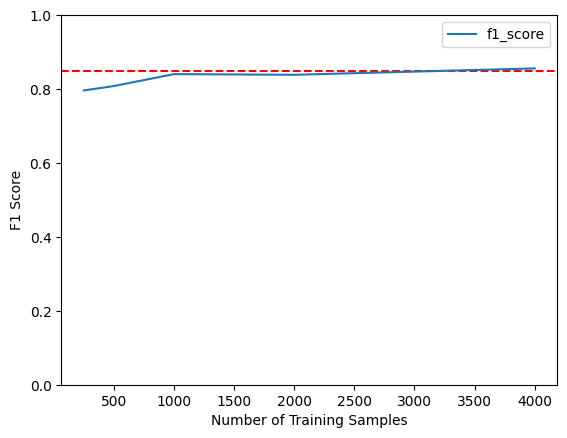

In [79]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [84]:
# @title Fine Tuning Multiple Languages at once
from datasets import concatenate_datasets
def concatenate_splits(corpora):

  multi_corpus = DatasetDict()

  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)

  return multi_corpus

In [85]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])


In [88]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size

training_args.push_to_hub = False

training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,tokenizer=xlmr_tokenizer,
                  train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()


Epoch,Training Loss,Validation Loss,F1
1,0.281300,0.201134,0.811200
2,0.148200,0.166832,0.849543
3,0.094300,0.172238,0.859978


TrainOutput(global_step=3219, training_loss=0.17455233571025, metrics={'train_runtime': 939.9029, 'train_samples_per_second': 54.772, 'train_steps_per_second': 3.425, 'total_flos': 1039776609142656.0, 'train_loss': 0.17455233571025, 'epoch': 3.0})

In [89]:
for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.869


F1-score of [de-fr] model on [fr] dataset: 0.852


F1-score of [de-fr] model on [it] dataset: 0.788


F1-score of [de-fr] model on [en] dataset: 0.657


In [92]:
#Training model on language corpus
corpora = [panx_de_encoded]
# Exclude German from iteration
for lang in langs[1:]:
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  # Fine-tune on monolingual corpus
  ds_encoded = encode_panx_dataset(pan_x[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  # Collect F1-scores in common dict
  f1_scores[lang][lang] = metrics["f1_score"][0]
  #Adding lang corpus to list
  corpora.append(ds_encoded)

Epoch,Training Loss,Validation Loss,F1
1,0.568600,0.356837,0.780851
2,0.256400,0.282951,0.826138
3,0.170800,0.280347,0.849047


Epoch,Training Loss,Validation Loss,F1
1,0.708400,0.296761,0.752800
2,0.280400,0.254116,0.806874
3,0.170000,0.257413,0.830235


Epoch,Training Loss,Validation Loss,F1
1,0.997700,0.563937,0.544283
2,0.481400,0.425939,0.666297
3,0.322900,0.432003,0.691704


In [93]:
#collating all the dataset and train a model with whole dataset with all languages
corpora_encoded = concatenate_splits(corpora)

training_args.logging_steps = len(corpora_encoded["train"]) // batch_size

training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,tokenizer=xlmr_tokenizer,
                  train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.297800,0.197711,0.811828
2,0.159500,0.171114,0.838805
3,0.099200,0.183876,0.852222


TrainOutput(global_step=3756, training_loss=0.1853918374949497, metrics={'train_runtime': 1151.201, 'train_samples_per_second': 52.172, 'train_steps_per_second': 3.263, 'total_flos': 1191051140259456.0, 'train_loss': 0.1853918374949497, 'epoch': 3.0})

In [95]:
for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {"de": f1_scores["de"],"each": {lang: f1_scores[lang][lang] for lang in langs},"all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8673,0.8484,0.7845,0.6317
each,0.8673,0.8463,0.8163,0.6955
all,0.8641,0.8679,0.8625,0.7819
